In [1]:
import os
from os import listdir
from os.path import isfile, join
# For data processing
import pandas as pd
import datetime as dt

# Matrix math
import numpy as np
import math

# For unnesting nested list/array
from itertools import chain

# Keras for deep learning
from keras.models import Sequential
from keras.layers.core import Dense, Activation, Dropout, Flatten
from keras.layers import LeakyReLU

# ARIMA
import statsmodels.api as sm
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller

# Scikit learn for mapping metrics
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error

#for logging
from time import time
import datetime as dt

#plotting
import matplotlib.pyplot as plt
import matplotlib.axes as ax
import seaborn as sns

# Attempt to utilize GPU
import tensorflow as tf
from tensorflow.python.client import device_lib

import operator
from functools import reduce
import winsound

Using TensorFlow backend.


In [2]:
device = tf.device("/device:GPU:0")
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 9446957518038599772
]


In [3]:
BLOCK = 'B'
df = pd.read_csv("Feat_Eng_B.csv", sep="\t", encoding='utf-8')
df.drop('Unnamed: 0', axis = 1, inplace=True)
# Drop Acorn as this can already be inferred
df.drop('Acorn', axis = 1, inplace=True)
# Drop variables due to missing data
df.drop('cloudCover',axis=1,inplace=True)
df.drop('dewPoint',axis=1,inplace=True)
df.drop('apparentTemperature',axis=1,inplace=True)
df.drop('visibility',axis=1,inplace=True)
df.drop('windSpeed',axis=1,inplace=True)
df.drop('windBearing',axis=1,inplace=True)
# Drop variables deemed irrelevant by statistical analysis
df.drop('pressure', axis=1, inplace=True)
# Sort values by smart meter
df = df[(df['Year'] < 2014) | ((df['Year'] == 2014) & (df['Month'] == 1) & (df['Day'] == 1) & (df['Hour'] < 1.5))]
df['LCLid'] = df['LCLid'].apply(str)
df = df[df['LCLid'] != '0']
df.reset_index(inplace=True, drop=True)

## Define Functions

In [4]:
def normalize_df(merged_df):
    vals = merged_df.values
    # Save relevant columns to list
    ## Save ID by period
    ## Normalize quantitative variables
    humidity = [(vals[i,5] / vals[i,18])-1 for i in range(len(vals))]
    temperature = [(vals[i,6] / vals[i,19])-1 for i in range(len(vals))]
    y_hat_mean = [(vals[i,14]  / vals[i,20])-1 for i in range(len(vals))]
    y_hat_std = [(vals[i,15] / vals[i,21])-1 for i in range(len(vals))]
    KWH = [vals[i,16] for i in range(len(vals))]
    ## Save Binaries
    isAutumn = [vals[i,7] for i in range(len(vals))]
    isSpring = [vals[i,8] for i in range(len(vals))]
    isSummer = [vals[i,9] for i in range(len(vals))]
    isHoliday = [vals[i,10] for i in range(len(vals))]
    isPeak = [vals[i,11] for i in range(len(vals))]
    isOff_Peak = [vals[i,12] for i in range(len(vals))]
    isWeekend = [vals[i,13] for i in range(len(vals))]
    # Save normalization factors to list
    #y_Normalization_Factors = [vals[i,14] for i in range(len(vals))]
    cols = ['humidity','Temperature', 'isAutumn', 'isSpring', 'isSummer', 'isHoliday', 
                'isPeak', 'isOff_Peak', 'isWeekend', 'y_hat_mean', 'y_hat_std', 'KWH_hh']
    new_df = pd.DataFrame(np.column_stack([humidity, temperature, isAutumn, isSpring, isSummer, isHoliday,
                                               isPeak, isOff_Peak, isWeekend, y_hat_mean, y_hat_std, KWH]), columns=cols).values
    #factors = y_Normalization_Factors
    return new_df#, factors #, ID

In [5]:
def feature_scaling(sm):
    # Create period columns from MACID, Year, Month, Day, Evening,Morning,Night Dummies
    sm["period"] = (sm.loc[:,"Year"].map(str) + sm.loc[:,"Month"].map(str) + sm.loc[:,"Day"].map(str) + sm.loc[:,"isPeak"].map(str) + sm.loc[:,"isOff_Peak"].map(str))
    # create aggregated object by 'period' 
    sm_ID_agg = sm.groupby('period')
    # Extract mean from aggregated list
    sm_aggregated_mean = sm_ID_agg.aggregate(np.mean)
    list_ = ['Year', 'Month', 'Day', 'Hour', 'isAutumn',
           'isSpring', 'isSummer', 'isHoliday', 'isPeak', 'isOff_Peak',
           'isWeekend']
    sm_aggregated_mean.drop(list_, axis = 1, inplace = True)
    # Merge sm with mean values on period IDs
    normalization_df = pd.merge(sm, sm_aggregated_mean, how="outer", on="period")
    # Normalize df, return normalizeD df and normalization factors
    raw_data = normalize_df(normalization_df) #factors
    return raw_data, list(sm["DateTime"]) #, factors

In [6]:
def model_data(raw_data, timestamps, days):
    # Amount of data that is used for training prediction
    sequence_length = days*48
    # Number of ending, up to, index for testing
    window_length = sequence_length+48
    #Convert the file to a list
    data = np.array(raw_data.tolist())  
    X_train = data[0:sequence_length, 0:len(data[0])-1]
    y_train = data[0:sequence_length, len(data[0])-1]
    X_test = data[sequence_length:window_length, 0:len(data[0])-1]
    y_test = data[sequence_length:window_length,len(data[0])-1]
    timestamps_test = timestamps[sequence_length:window_length]
    return X_train, y_train, X_test, y_test, list(timestamps_test)

In [7]:
def initialize_model(X_train, loss_function, optimizer):
    #Create a Sequential model using Keras
    model = Sequential()
    #First MLP layer
    model.add(Dense(13,input_shape=(X_train.shape[1],)))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Dropout(0.1))
    #Second MLP layer
    model.add(Dense(169))
    model.add(LeakyReLU(alpha=0.3))
    model.add(Dropout(0.25))
    #third MLP layer
    model.add(Dense(13))
    model.add(LeakyReLU(alpha=0.2))
    #Output layer (returns the predicted value)
    model.add(Dense(1))
    model.add(LeakyReLU(alpha=0.1))
    #Set loss function and optimizer
    model.compile(loss=loss_function, optimizer=optimizer)
    return model

In [8]:
def fit_model(model, X_train, Y_train, batch_num, num_epoch, val_split):
    #Train the model on X_train and Y_train
    with tf.device('/device:GPU:0'):
        model.fit(X_train, Y_train, batch_size= batch_num, epochs=num_epoch, validation_split= val_split, verbose = 0)
    return model

In [9]:
def test_model(model, X_test):
    #Test the model on X_Test
    with tf.device('/device:GPU:0'):
        y_predict = model.predict(X_test)
    return y_predict

In [10]:
def cluster_predict_365(df, train_days, test_days):
    df, timestamps = feature_scaling(df)
    # Initialize predictions list
    predictions = []
    #Record the time the model starts training
    start = time()
    # Initialize iteration value
    i = 0
    while i < test_days:
        X_train, y_train, X_test, y_test, timestamps_test = model_data(df, timestamps, train_days)
        model = initialize_model(X_train, loss_function='mean_squared_error', optimizer='adam')
        model = fit_model(model, X_train, y_train, batch_num = 64, num_epoch = 500, val_split = .2)
        y_predict = test_model(model, X_test)
        for x in range(len(y_predict)):
            predictions.append([y_predict[x][0], y_test[x], timestamps_test[x]])
        df = df[48:,:]
        timestamps = timestamps[48:]
        if i == 0:
            proc_time = int(math.floor(time() - start))
            print('1-level predictions for ', BLOCK, ' for ', i, ' days in ', proc_time, ' seconds')
        if i % 30 == 0:
            print('Epoch: ',i)
        i += 1
    proc_time = int(math.floor(time() - start))
    print('Predictions for ', BLOCK, ' takes ', proc_time, ' seconds, for ', i, ' days.')
    
    ## Merge Data
    predictions = np.array(predictions)
    pred_all = pd.DataFrame({'y_test':predictions[:,0], 'y_hat': predictions[:,1], 'DateTime': predictions[:,2]}) 
    pred_all.to_csv(("Cluster_"+BLOCK+"_2ndLvL_predictions.csv"), sep="\t", encoding='utf-8')
    return pred_all

In [11]:
def mean_absolute_percentage_error(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

In [12]:
def calculate_statistics(y_predict, Y_test, correlate = False):
    #Get Mean Squared Error
    RMSE = math.sqrt(mean_squared_error(Y_test, y_predict))
    # Get Mean Absolute Error
    MAPE = mean_absolute_percentage_error(Y_test, y_predict)
    
    # empty value for corr
    corr = np.nan
    # conditional to execute correlation
    if correlate == True:
        # Get Pearson product-moment correlation coefficients
        corr = np.corrcoef(Y_test, y_predict)[1][0]**2
    return RMSE, MAPE, corr

## Putting it together

### Step 1. Data Engineering

In [13]:
# Return all values within current directory
arr = os.listdir()
# Save each string within arr that starts with 'MAC', namely smart meter ID
smart_preds = [arr[i] for i in range(len(arr)) if arr[i][:3] == 'MAC']
# Read all smart meter files within working directory
frame = pd.DataFrame()
list_ = []
for file_ in smart_preds:
    sm = pd.read_csv(file_,index_col=None, header=0, sep="\t", encoding='utf-8')
    list_.append(sm)
# Merge all smart meter prediction outputs, and print head of merged df
smart_preds = pd.concat(list_)
smart_preds.drop('Unnamed: 0', axis = 1, inplace=True)
smart_preds.head()

,LCLid,DateTime,y_test,y_hat
0,MAC001966,2012-12-01 23:30,0.129,0.610209
1,MAC001966,2012-12-02 00:00,0.166,0.440082
2,MAC001966,2012-12-02 00:30,0.181,0.440470
3,MAC001966,2012-12-02 01:00,0.119,0.440858
4,MAC001966,2012-12-02 01:30,0.237,0.447490


In [14]:
# Print performance metrics between predicted and actual values
RMSE_1, MAPE_1, corr_1 = calculate_statistics(smart_preds.y_hat, smart_preds.y_test, correlate = True)
print("Root Mean Squared Error:", RMSE_1)
print("Mean Absolute Percentage Error:", MAPE_1)
print("Correlation:", corr_1)

Root Mean Squared Error: 0.9196549365334932
Mean Absolute Percentage Error: 89.46409412
Correlation: 0.00308321316556


In [15]:
# Due to large difference convert abnormal predictions to the largest observed instance
print('max value of actual consumption is', smart_preds.y_test.max())
print('max value of predicted consumption is', smart_preds.y_hat.max())
smart_preds.y_hat[smart_preds.y_hat > smart_preds.y_test.max()] = smart_preds.y_test.max()

max value of actual consumption is 3.3789999
max value of predicted consumption is 102.19653


C:\Users\gebruiker\Anaconda3\lib\site-packages\ipykernel\__main__.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [16]:
# Print new performance metric results based on max imputations
RMSE_2, MAPE_2, corr_2 = calculate_statistics(smart_preds.y_hat, smart_preds.y_test, correlate = True)
print("Root Mean Squared Error:", RMSE_2)
print("Mean Absolute Percentage Error:", MAPE_2)
print("Correlation:", corr_2)

Root Mean Squared Error: 0.327250821881925
Mean Absolute Percentage Error: 83.9356833882
Correlation: 0.0886568540345


In [17]:
smart_preds_agg = smart_preds.groupby(['DateTime'], as_index=False).agg({'y_hat': 'mean', 'y_test':'mean'})
smart_preds_agg.head()

,DateTime,y_hat,y_test
0,2012-12-01 23:30,0.638834,0.2822
1,2012-12-02 00:00,0.389883,0.2116
2,2012-12-02 00:30,0.389897,0.2304
3,2012-12-02 01:00,0.389911,0.1558
4,2012-12-02 01:30,0.386326,0.1750


## Predictions

In [18]:
df.head()

,LCLid,Year,Month,Day,Hour,DateTime,humidity,temperature,StdorToU,isAutumn,isSpring,isSummer,isWinter,isHoliday,isPeak,isOff_Peak,isNight,isWeekend,KWH_hh
0,MAC001966,2012,11,1,0.0,2012-11-01 00:00,0.82,11.193333,1,1,0,0,0,0,0,0,1,0,0.162
1,MAC003355,2012,11,1,0.0,2012-11-01 00:00,0.82,11.193333,1,1,0,0,0,0,0,0,1,0,0.248
2,MAC003445,2012,11,1,0.0,2012-11-01 00:00,0.82,11.193333,1,1,0,0,0,0,0,0,1,0,0.507
3,MAC003876,2012,11,1,0.0,2012-11-01 00:00,0.82,11.193333,1,1,0,0,0,0,0,0,1,0,0.139
4,MAC004567,2012,11,1,0.0,2012-11-01 00:00,0.82,11.193333,1,1,0,0,0,0,0,0,1,0,0.054


## Looping throughout the year

In [19]:
# Remove StdorToU variable as it says nothing on aggregated level, no information to model. 
ann_df = df.groupby(['DateTime'], as_index=False).agg({'humidity': 'mean',
       'temperature': 'mean', 'isAutumn': 'mean', 'isWinter': 'mean', 'isSpring': 'mean', 'isSummer': 'mean',
       'isHoliday': 'mean', 'isPeak': 'mean', 'isOff_Peak': 'mean', 'isWeekend': 'mean', 'KWH_hh': 'mean'})
# Remove dummy trap colums
trap_dummies = ['isWinter']
ann_df.drop(trap_dummies, axis = 1, inplace = True)
print(ann_df.shape)

(20451, 11)


In [20]:
# Aggregate all smart meter data and return the mean and standard deviations of kWh consumption per timestamp
agg_smart_preds = smart_preds.groupby(['DateTime'], as_index=False).agg({'y_hat': 'mean'})
agg_smart_preds['y_hat_std'] =  smart_preds.groupby(['DateTime'], as_index=False).agg({'y_hat': 'std'}).iloc[:,1]
agg_smart_preds.rename(columns={'y_hat':'y_hat_mean'}, inplace=True)
agg_smart_preds.head()

,DateTime,y_hat_mean,y_hat_std
0,2012-12-01 23:30,0.638834,0.107782
1,2012-12-02 00:00,0.389883,0.055072
2,2012-12-02 00:30,0.389897,0.054253
3,2012-12-02 01:00,0.389911,0.053470
4,2012-12-02 01:30,0.386326,0.051597


In [21]:
### This section merges the ann_df with all weather and time parameters with outputs from the agg_smart_preds df
cluster = pd.merge(ann_df, agg_smart_preds, on=['DateTime'], how = 'right')
# Convert time column to datetime columns
cluster['DateTime'] = pd.to_datetime(cluster['DateTime'], errors='coerce')
cluster['Year'] = cluster['DateTime'].dt.year
cluster['Month'] = cluster['DateTime'].dt.month
cluster['Day'] = cluster['DateTime'].dt.day
cluster['Hour'] = cluster['DateTime'].dt.hour
cluster['Minute'] = cluster['DateTime'].dt.minute
cluster['Hour'][cluster['Minute'] == 30] = .5
cluster.drop(['Minute'], axis = 1, inplace=True)
# Reorder columns to have target as last column
cluster = cluster.loc[:,['DateTime', 'Year', 'Month', 'Day', 'Hour', 'humidity', 'temperature', 'isAutumn', 'isSpring', 'isSummer',
       'isHoliday', 'isPeak', 'isOff_Peak', 'isWeekend', 'y_hat_mean','y_hat_std', 'KWH_hh' ]]
cluster.head()

C:\Users\gebruiker\Anaconda3\lib\site-packages\ipykernel\__main__.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


,DateTime,Year,Month,Day,Hour,humidity,temperature,isAutumn,isSpring,isSummer,isHoliday,isPeak,isOff_Peak,isWeekend,y_hat_mean,y_hat_std,KWH_hh
0,2012-12-01 23:30:00,2012,12,1,0.5,0.849,0.451667,0,0,0,0,1,0,1,0.638834,0.107782,0.2822
1,2012-12-02 00:00:00,2012,12,2,0.0,0.848,0.131111,0,0,0,0,0,0,1,0.389883,0.055072,0.2116
2,2012-12-02 00:30:00,2012,12,2,0.5,0.850,0.120000,0,0,0,0,0,0,1,0.389897,0.054253,0.2304
3,2012-12-02 01:00:00,2012,12,2,1.0,0.852,0.108889,0,0,0,0,0,0,1,0.389911,0.053470,0.1558
4,2012-12-02 01:30:00,2012,12,2,0.5,0.860,-0.132222,0,0,0,0,0,0,1,0.386326,0.051597,0.1750


In [22]:
ann_2_lvl = cluster_predict_365(cluster, train_days = 31, test_days=364)

1-level predictions for  B  for  0  days in  27  seconds
Epoch:  0
Epoch:  30
Epoch:  60
Epoch:  90
Epoch:  120
Epoch:  150
Epoch:  180
Epoch:  210
Epoch:  240
Epoch:  270
Epoch:  300
Epoch:  330
Epoch:  360
Predictions for  B  takes  42185  seconds, for  364  days.


In [23]:
ann_2_lvl_RMSE, ann_2_lvl_MAPE, corr_2 = calculate_statistics(ann_2_lvl.y_test.values, ann_2_lvl.y_hat.values, correlate = False)
print("Root Mean Squared Error:", ann_2_lvl_RMSE)
print("Mean Absolute Percentage Error:", ann_2_lvl_MAPE)

Root Mean Squared Error: 1.9187674893228204
Mean Absolute Percentage Error: 46.8700475336


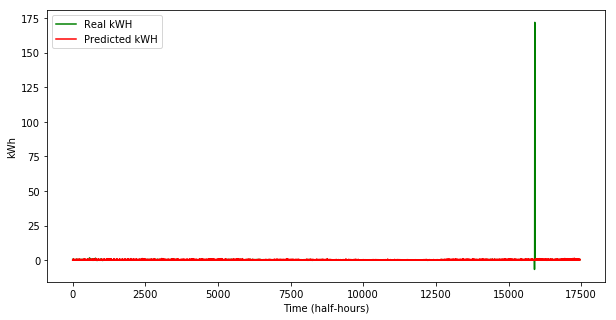

In [24]:
#Plot of the predicted prices versus the real prices
fig = plt.figure(figsize=(10,5))
ax = fig.add_subplot(111)
plt.plot(ann_2_lvl.y_test.values, color = 'green', label = 'Real kWH')
plt.plot(ann_2_lvl.y_hat.values, color = 'red', label = 'Predicted kWH')
ax.set_ylabel("kWh")
ax.set_xlabel("Time (half-hours)")
ax.legend()

In [25]:
#frequency = 800  # Set Frequency To 2500 Hertz
#duration = 5000  # Set Duration To 1000 ms == 1 second
#winsound.Beep(frequency, duration)